# Neural Network Model Tuning

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is manual tuning / evaluation of hyperparameters

# Table of Contents

### - [Neural Net Architecture](#NN)
- imported from .py file

### - [Initial Grid Search for HyperParameters](#HYPER)
- selects optimization metric

### - [SHAP Values for Feature Importance](#SHAP)
        - used for narrowing down to most important features

### - [Feature Selection Using SHAP order](#FEATURE)

### - [Best Model with Epochs](#BEST)
- saves values to .json file and .pth file

### - [Confusion Matrix](#MATRIX)
- assesses probability distribution and states

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [1]:
# file structure libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pickle

# # visualization libraries
from matplotlib import pyplot as plt
#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('seaborn-v0_8-darkgrid')
#plt.style.use('bmh')
#plt.style.use('dark_background')
#plt.style.use('fivethirtyeight')
%matplotlib inline
# import seaborn as sns

# # ML libraries
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay#, roc_curve
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# # for sigmoid function, in case we need to manually implement in LR
# from scipy.stats import logistic

import torch
import torch.nn as nn
import torch.optim as optim
import shap

In [2]:
# start of notebook
from datetime import datetime
start_time = datetime.now()
print('start time:', str(start_time))

start time: 2023-06-08 02:56:30.655009


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

4

In [5]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


In [6]:
# our system has 8 GPUs
# we won't need them all at the same time but can be helpful

device_0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device_2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device_3 = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device_4 = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
device_5 = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
device_6 = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
device_7 = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

devices = [
    device_0,
    device_1,
    device_2,
    device_3,
    device_4,
    device_5,
    device_6,
    device_7,
]

In [7]:
# SELECT YOUR DEVICE FOR THIS NOTEBOOK
idx = 3
device = devices[idx] # change index to select
device

device(type='cuda', index=3)

## Neural Net <a id="NN">

In [8]:
# load in the model class
import sys
sys.path.append("../../app/model/")
import ModelNN as Net

In [9]:
import inspect

# we've defined multiple architectures to select from
for name, obj in inspect.getmembers(Net):
    if inspect.isclass(obj):
        print(obj)

<class 'ModelNN.Net'>
<class 'ModelNN.OneLayer'>
<class 'ModelNN.ThreeLayer'>
<class 'ModelNN.TwoLayer'>


In [10]:
# LOAD IN DATA
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open("../../data/train_test_data.pkl", "rb"))

print("X_train: ", X_train_df.shape)
print("X_test: ", X_test_df.shape)
print("\n")
print("y_train: ", y_train_df.shape)
print("y_test: ", y_test_df.shape)

X_train:  (1192, 13)
X_test:  (271, 13)


y_train:  (1192,)
y_test:  (271,)


# Grid Search for HyperParameter Tuning <a id="HYPER">
    
- optimize grid search with different model metrics to decide on optimal path forward

In [11]:
# # list of functions
# metrics =[
#     recall_score,
#     f1_score,
#     roc_auc_score,
# ]

# # create dataframe to track performance on metric criteria
# index=[metric.__name__ for metric in metrics]
index = ['score']

columns=[
    'test_accuracy',
    'test_precision',
    'test_recall',
    'test_f1_score',
    'test_auc',
    'training_loss',
    'validation_loss',
    'epochs',
    'hyper_params' # this will be a dictionary
]

param_df = pd.DataFrame(index=index,
                        columns=columns)

param_df

,test_accuracy,test_precision,test_recall,test_f1_score,test_auc,training_loss,validation_loss,epochs,hyper_params
score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# manually set parameters

params = {
    # all features
    'features': [
        'peak_i15_mmh',
        'contributingarea_km2',
        'prophm23',
        'dnbr1000',
        'kf',
        'Fine fuel load',
        'SAV',
        'Packing ratio',
        'Extinction moisture content',
        'LNDS_RISKS',
        'fire_interval',
        'SedUn',
        'SuscFrac',
    ],
    'hidden_size': 100,
    'lr': 0.01,
    'dropout_rate': 0.10,
    'epochs': 500,
    'grid_search_metric': 'roc_auc_score',
}

In [19]:
# # manually set features
# feat_subset = [
#     'peak_i15_mmh',
#     'fire_interval',
#     'kf',
#     'SuscFrac',
#     'SAV',
#     'prophm23',
#     'SedUn'
# ]

# params['features'] = feat_subset

In [20]:
params

{'features': ['peak_i15_mmh',
  'contributingarea_km2',
  'prophm23',
  'dnbr1000',
  'kf',
  'Fine fuel load',
  'SAV',
  'Packing ratio',
  'Extinction moisture content',
  'LNDS_RISKS',
  'fire_interval',
  'SedUn',
  'SuscFrac'],
 'hidden_size': 100,
 'lr': 0.01,
 'dropout_rate': 0.1,
 'epochs': 500,
 'grid_search_metric': 'roc_auc_score'}

In [21]:
# configured to be consistent in rest of notebook
# can scroll down and customize at each training step
n_epochs = params['epochs']
print(n_epochs)

500


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Architecture:  TwoLayer
13  features: 
['peak_i15_mmh', 'contributingarea_km2', 'prophm23', 'dnbr1000', 'kf', 'Fine fuel load', 'SAV', 'Packing ratio', 'Extinction moisture content', 'LNDS_RISKS', 'fire_interval', 'SedUn', 'SuscFrac']
hyperparameters:
dropout_rate: 0.1
hidden_size: 100
lr: 0.01


Epochs: 500
Training loss: 0.014998295344412327
Validation loss: 2.0538461208343506


Training accuracy: 0.9949664429530202
Test accuracy: 0.8523985239852399


Precision (test): 0.6415094339622641


Recall (test): 0.6181818181818182


F1 Score (test): 0.6296296296296297


AUC (test): 0.8768939393939393


CPU times: user 1.2 s, sys: 65.9 ms, total: 1.27 s
Wall time: 1.19 s


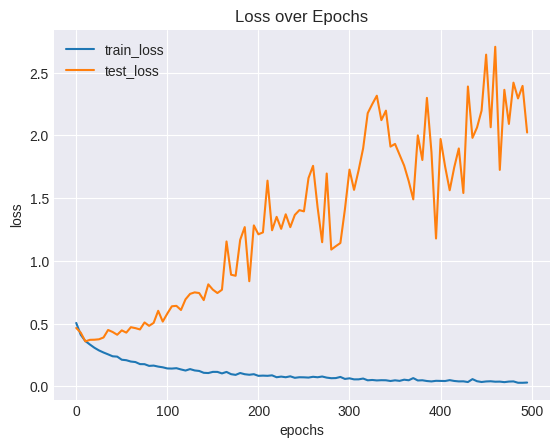

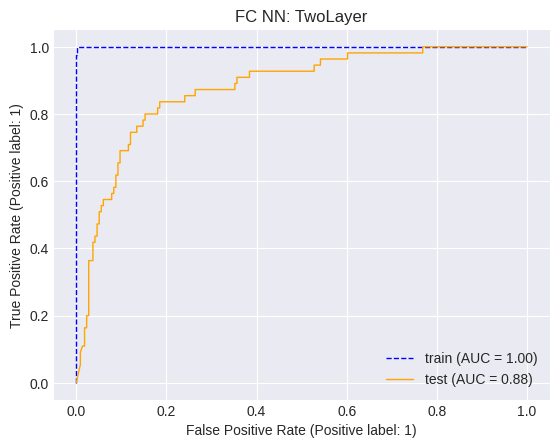

In [22]:
%%time
# MANUAL TRAINING
if __name__ == '__main__':
    # and sticking with naming convention for feature subset selection
    X_train = X_train_df[params['features']]
    X_test = X_test_df[params['features']]
    y_train = y_train_df
    y_test = y_test_df
    
    #scale the data X_train and X_test
    cols = X_train.columns
    sc = StandardScaler()
    X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(sc.transform(X_test), columns=cols)
    
    # change datatype for pytorch
    # send to gpu if available
    X_train_tensor = torch.tensor(X_train.values).float().to(device)
    X_test_tensor = torch.tensor(X_test.values).float().to(device)
    y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1).to(device)
    y_test_tensor = torch.tensor(y_test.values).float().view(-1, 1).to(device)
    
    # hyperparameters
    input_size = X_train.shape[1]
    hidden_size = params['hidden_size']
    learning_rate = params['lr'] # 0.001 is default value for Adam optimizer
    dropout_rate = params['dropout_rate']
    output_size = 1 # in our case this is always 0ne

    # select architecture
    # send to gpu if available
    #model = Net.OneLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
    model = Net.TwoLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
    #model = Net.ThreeLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
        
    # make sure model is in training mode, calculates gradients etcs
    model.train()
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    ## Train the Model ##
    
    # empty df to track loss over epochs
    loss_df = pd.DataFrame(columns=['train_loss', 'test_loss'])
    
    for epoch in range(n_epochs):
        y_train_pred_proba = model(X_train_tensor)
        loss = criterion(y_train_pred_proba, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%5 ==0:
            y_train_pred_proba = model(X_train_tensor)
            y_test_pred_proba = model(X_test_tensor)

            train_loss = criterion(y_train_pred_proba, y_train_tensor)
            val_loss = criterion(y_test_pred_proba, y_test_tensor)
            
            loss_df.loc[epoch, 'train_loss'] = train_loss.detach().cpu().numpy().flatten()[0]
            loss_df.loc[epoch, 'test_loss'] = val_loss.detach().cpu().numpy().flatten()[0]

    # turn off dropout etc
    model.eval()
    ## now "final" probability outputs from trained model ##
    y_train_pred_proba = model(X_train_tensor)
    y_test_pred_proba = model(X_test_tensor)     

    # loss on the final output
    # this isn't really meaningful without seeing change over epochs 
    # occasionally handy to reference
    train_loss = criterion(y_train_pred_proba, y_train_tensor).detach().cpu().numpy().flatten()[0]
    val_loss = criterion(y_test_pred_proba, y_test_tensor).detach().cpu().numpy().flatten()[0]

    # # convert these values back to pandas dtypes
    y_train_pred_proba = y_train_pred_proba.detach().cpu().numpy() # numpy goes back to cpu
    y_test_pred_proba = y_test_pred_proba.detach().cpu().numpy()  # numpy goes back to cpu
    # also get their boolean values
    y_train_pred_bool = np.round(y_train_pred_proba)
    y_test_pred_bool = np.round(y_test_pred_proba)

    # calculate accuracy
    train_accuracy = accuracy_score(y_train_df, y_train_pred_bool.flatten())
    test_accuracy = accuracy_score(y_test_df, y_test_pred_bool.flatten())

    # calculate precision
    test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
    
    # calculate recall
    test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)
    
    # calculate f1
    f1_test = f1_score(y_test_df, y_test_pred_bool)

    # extract AUC for printing
    auc_test = roc_auc_score(y_test_df, y_test_pred_proba)  

    # and if this is the best, update the dateframe with the given metrics
    param_df.loc['score', 'test_accuracy'] = float(test_accuracy)
    param_df.loc['score', 'test_precision'] = float(test_precision)
    param_df.loc['score', 'test_recall'] = float(test_recall_score)
    param_df.loc['score', 'test_f1_score'] = float(f1_test)
    param_df.loc['score', 'test_auc'] = float(auc_test)
    param_df.loc['score', 'training_loss'] = float(train_loss)#.detach().numpy().flatten()[0]
    param_df.loc['score', 'validation_loss'] = float(val_loss)#.detach().numpy().flatten()[0]
    param_df.loc['score', 'epochs'] = n_epochs         
    # to insert hyparams into df...pack as a list of tuples
    params_list = [tuple(pair) for pair in params.items()]
    # insert as a list
    # to unpack later call... `dict(best_params)`
    param_df.loc['score', 'hyper_params'] = params_list   
    
    
    
    # to be saved to json
    # must convert float type for serialization
    performance_summary = {
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'train_accuracy': float(train_accuracy),
        'test_accuracy': float(test_accuracy),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall_score),
        'test_f1_score': float(f1_test),
        'test_auc': float(auc_test),
    }
    
    
    
    ##
    ## display performance summary ##
    ##
    model_name = model.__class__.__name__
    print(f'Architecture:  {model_name}')
    print(len(params['features']), " features: ")
    print(params['features'])
    print('hyperparameters:')
    param_keys = ['dropout_rate', 'hidden_size', 'lr']
    for key in param_keys:
        print(key + ":", params[key])
    print("\n")
    print(f'Epochs: {n_epochs}')
    print(f'Training loss: {train_loss}')
    print(f'Validation loss: {val_loss}')
    print("\n")

    # accuracy
    print(f'Training accuracy: {train_accuracy}')
    print(f'Test accuracy: {test_accuracy}')
    print('\n')

    # precision
    print(f'Precision (test): {test_precision}')
    print('\n')    
    
    # recall
    print(f'Recall (test): {test_recall_score}')
    print('\n')

    # f1
    print(f'F1 Score (test): {f1_test}')
    print('\n')

    # AUC
    print(f'AUC (test): {auc_test}')
    print('\n')
    
    # PLOTS
    
    # Loss plot
    fig = loss_df.plot()
    fig.set_xlabel('epochs')
    fig.set_ylabel('loss')
    fig.set_title('Loss over Epochs');

    # AUC plot
    fig, ax = plt.subplots()

    RocCurveDisplay.from_predictions(y_train_df, 
                                     y_train_pred_proba, 
                                     ax=ax, 
                                     linewidth=1, 
                                     color='blue', 
                                     name='train', 
                                     linestyle="dashed"
                                    );

    RocCurveDisplay.from_predictions(y_test_df, 
                                     y_test_pred_proba,
                                     ax=ax, 
                                     linewidth=1, 
                                     color='orange', 
                                     name='test');

    plt.title(f'FC NN: {model_name}');

    # save final model weights
    # torch.save(model.state_dict(), f'../model/{model_name}.pth')

OLD WITH ALL FEATURES (TWO LAYERS)
- BEST PERFORMANCE SO FAR!!!
- DO NOT DELETE!!!

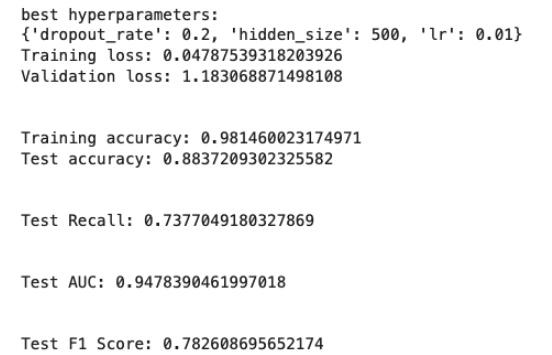

In [23]:
param_df.T

,score
test_accuracy,0.852399
test_precision,0.641509
test_recall,0.618182
test_f1_score,0.62963
test_auc,0.876894
training_loss,0.014998
validation_loss,2.053846
epochs,500
hyper_params,"[(features, [peak_i15_mmh, contributingarea_km..."


## Notes along the way

- 

# SHAP Values<a id="SHAP">

- First train model with best hyperparameters / tuning metric

- Examine the Shap values for feature importance
    - we likely need to reduce the number of features to prevent overfitting

In [16]:
explainer = shap.DeepExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_test_tensor)
print(shap_values.shape)
vals = np.abs(shap_values).mean(0)
shap_val_df = pd.DataFrame(data=vals, index=X_test_df.columns, columns=['vals'])
shap_val_df = shap_val_df.sort_values(by='vals', ascending=False)
shap_val_df

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(271, 13)


,vals
peak_i15_mmh,0.143278
fire_interval,0.042102
SuscFrac,0.035746
kf,0.035353
prophm23,0.033662
dnbr1000,0.027589
SAV,0.027077
SedUn,0.026190
Extinction moisture content,0.025811
LNDS_RISKS,0.018393


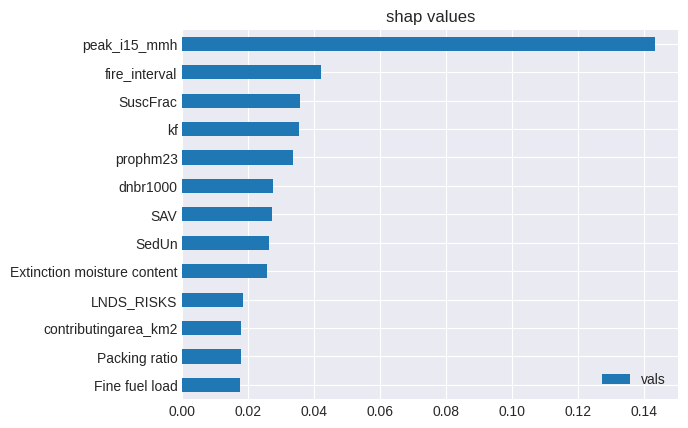

In [17]:
shap_val_df[::-1].plot(kind='barh', title='shap values');

In [18]:
feat_order = list(shap_val_df.index)
feat_order

['peak_i15_mmh',
 'fire_interval',
 'SuscFrac',
 'kf',
 'prophm23',
 'dnbr1000',
 'SAV',
 'SedUn',
 'Extinction moisture content',
 'LNDS_RISKS',
 'contributingarea_km2',
 'Packing ratio',
 'Fine fuel load']

In [19]:
# # open the parameters json
# import json

# file_path = "../../model/model_parameters.json"
# with open(file_path) as model_params:
#     model_params = json.load(model_params)

# model_params

## save the model parameters
- architecture name + epochs
- features / hyperparameters
- weights and biases

In [20]:
# check if parameters file exists
# if not, create it
import os
import json

file_path = "../../app/model/model_parameters.json"
if os.path.isfile(file_path) == True:
    print("parameter json already exists")
else:
    print("created empty json file")
    model_params = {} # create empty dict
    with open(file_path, "w") as json_file:
        json.dump(model_params, json_file)

parameter json already exists


In [21]:
# open the parameters json
file_path = "../../app/model/model_parameters.json"
with open(file_path) as model_params:
    model_params = json.load(model_params)

# model_params

In [22]:
# save final model weights
architecture = model_name + "_" + str(n_epochs) + "_epochs" + "_manual_tuning"
# torch.save(model.state_dict(), f'../../app/model/{architecture}.pth')

# and hyperparameters
new_params = {}
new_params['features'] = params['features']
new_params['hidden_size'] = params['hidden_size']
new_params['lr'] = params['lr']
new_params['dropout_rate'] = params['dropout_rate']
new_params['epochs'] = n_epochs
new_params['model_class'] = model_name
new_params['weights'] = f'{architecture}.pth'
new_params['grid_search_metric'] = 'na'
new_params['performance_summary'] = performance_summary

# assign to the json
model_params[architecture] = new_params
# and view the final output
print(architecture)
model_params[architecture]

TwoLayer_750_epochs_manual_tuning


{'features': ['peak_i15_mmh',
  'contributingarea_km2',
  'prophm23',
  'dnbr1000',
  'kf',
  'Fine fuel load',
  'SAV',
  'Packing ratio',
  'Extinction moisture content',
  'LNDS_RISKS',
  'fire_interval',
  'SedUn',
  'SuscFrac'],
 'hidden_size': 500,
 'lr': 0.01,
 'dropout_rate': 0.2,
 'epochs': 750,
 'model_class': 'TwoLayer',
 'weights': 'TwoLayer_750_epochs_manual_tuning.pth',
 'grid_search_metric': 'na',
 'performance_summary': {'train_loss': 0.010428668931126595,
  'val_loss': 2.029296398162842,
  'train_accuracy': 0.9949664429530202,
  'test_accuracy': 0.8782287822878229,
  'test_precision': 0.7291666666666666,
  'test_recall': 0.6363636363636364,
  'test_f1_score': 0.6796116504854369,
  'test_auc': 0.8946969696969698}}

In [23]:
# # write out the file
# file_path = "../../app/model/model_parameters.json"
# with open(file_path, "w") as json_file:
#     json.dump(model_params, json_file)
#     print("hyperparameters saved!")

# Confusion Matrix <a id="MATRIX">
- assess probabilities
- is the loss for test set high due to outliers, particular states, etc

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [25]:
# bring in full file
# will need for geographic assessment of confusion matrix
file_path = "../../data/data_v08_consolidated.parquet"
df = gpd.read_parquet(file_path)

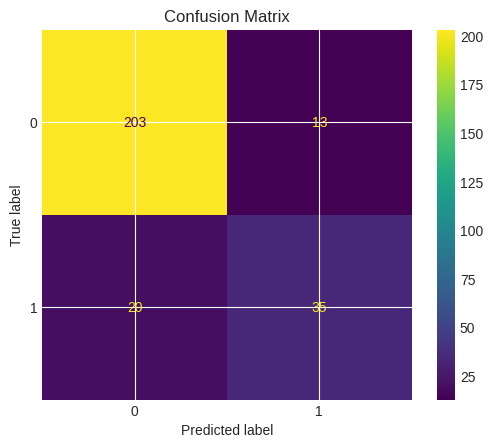

In [26]:
cm = confusion_matrix(y_test_df, y_test_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
plt.title('Confusion Matrix');

In [27]:
# pd.set_option('display.float_format', lambda x: '%.7f' % x)

In [28]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test_df).astype(int).rename(columns={'response': 'y_test'})
# predicted values
test_assess['y_test_pred'] = y_test_pred_bool.flatten().astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred_proba.flatten().astype(np.float16) # reduce precision to prevent downstream errors

# create column for confusion matrix
# we'll use this to assess the probabilities
# there's a dataframe for each of these if needed
TP = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == True)]
FP = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == False)]
TN = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == True)]
FN = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]

test_assess.loc[TP.index,'confusion'] = 'TP'
test_assess.loc[FP.index,'confusion'] = 'FP'
test_assess.loc[TN.index,'confusion'] = 'TN'
test_assess.loc[FN.index,'confusion'] = 'FN'

# bring in the state values
test_assess = pd.merge(test_assess, df['state'], how='left', left_index=True, right_index=True)

test_assess

,y_test,y_test_pred,pred_correct,y_test_pred_proba,confusion,state
2,0,0,True,0.000000,TN,CA
6,0,0,True,0.000000,TN,CA
10,0,0,True,0.000000,TN,CA
29,1,1,True,1.000000,TP,ID
35,1,1,True,1.000000,TP,ID
...,...,...,...,...,...,...
1446,0,0,True,0.000000,TN,AZ
1447,0,1,False,0.964844,FP,AZ
1448,0,0,True,0.000000,TN,AZ
1449,0,0,True,0.000000,TN,AZ


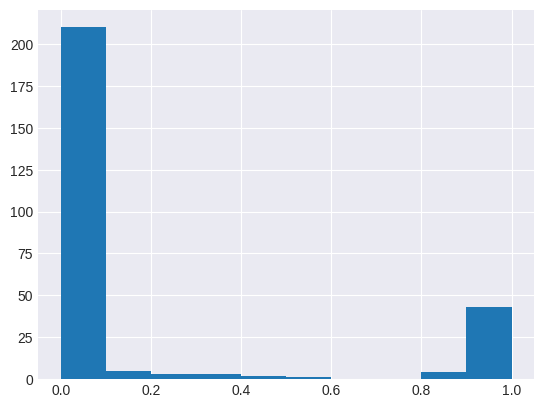

In [29]:
# overall probability distribution
test_assess['y_test_pred_proba'].hist();

In [30]:
# records were there was actually YES debris flow
subset = ['TP', 'FN']
flows = test_assess[test_assess['confusion'].isin(subset)]

# records were there was actually NO debris flow
subset = ['TN', 'FP']
no_flows = test_assess[test_assess['confusion'].isin(subset)]

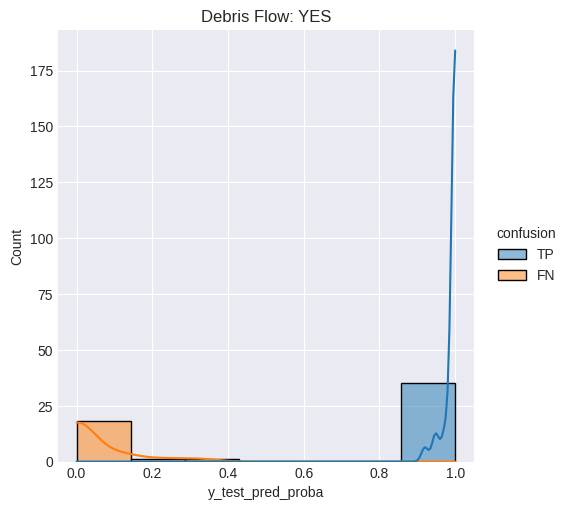

In [31]:
sns.displot(data=flows, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: YES');

In [32]:
# # seaborn has a hard time with the really small probabilities
# sns.displot(data=no_flows, x='y_test_pred_proba', hue='confusion', kde=True);
# plt.title('Debris Flow: NO');

In [ ]:
# seaborn has a hard time with the really small probabilities
temp = no_flows[no_flows['y_test_pred_proba'].astype(str).str.len() < 9]
sns.displot(data=temp, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: NO');

In [ ]:
# this let's us see where are performance is coming from
# it's the percentage of each metric by state
state_matrix = test_assess.groupby(['confusion'])['state'].value_counts(normalize=True).unstack().fillna(0)#.astype(int)
state_matrix = state_matrix.loc[['TP', 'FN', 'TN', 'FP'],:]
state_matrix

In [ ]:
test_assess['confusion'].value_counts()

In [ ]:
# we can use this to determine
# is our confusion matrix is overindexing on certain state(s)
state_counts = test_assess['state'].value_counts(normalize=True).sort_index()
state_counts

In [ ]:
confusion_index = state_matrix.div(state_counts) - 1
confusion_index

In [ ]:
confusion_index.plot(kind='barh').invert_yaxis();
plt.title('Confusion Index by State');

In [ ]:
# end of notebook
end_time = datetime.now()
print('end time:', str(end_time))
elapsed_time = end_time - start_time
print('elapsed time:', str(elapsed_time))